# Continuous learning for image classification task

###Import needed packages

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from keras.models import Sequential,Input,Model
from keras.layers import Conv2D, MaxPooling2D, ReLU,  Flatten , Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras import backend as k
from keras.utils.vis_utils import plot_model
import time

**DESCRIPTION OF THE CODE**: 

The selected dataset is the **Colorectal Histology** and it has been chosen among one of the **Tensorflow** [standard datasets](https://www.tensorflow.org/datasets/catalog/colorectal_histology). It allows for the building of image classification models: indeed the dataset contain 5000 3 channels RGB histological images, divided into 8 different classes that are $$\texttt{['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adipose', 'Empty']}$$ depending on the type of tissue saw in each image. Images have a resolution equal to (150x150) pixels. As we can see (in the following cells), dataset samples are perfectly distributed across all the classes.

###Download the dataset

In [ ]:
# Download the selected dataset splitting it as :
# -70% training set;
# -15% validation set;
# -15% test set;

(training_set, validation_set, test_set), dataset_info = tfds.load(
    'colorectal_histology',
    split=['train[:70%]', 'train[70%:85%]','train[85%:]'],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteASD2NY/colorectal_histology-train.tfrecord


  0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


###Exploratory Data Analysis

In [ ]:
# Check amount of samples in each set
len(training_set),len(validation_set),len(test_set)

(3500, 750, 750)

In [ ]:
# Visualize general info on the datasset
dataset_info

tfds.core.DatasetInfo(
    name='colorectal_histology',
    version=2.0.0,
    description='Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.',
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(150, 150, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    }),
    total_num_examples=5000,
    splits={
        'train': 5000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kather, Jakob Nikolas and Weis, Cleo-Aron and Bianconi, Francesco and Melchers, Susanne M and Schad, Lothar R and Gaiser, Timo and Marx, Alexander and Z{"o}llner, Frank Gerrit},
      journal={Scientific reports},
      volume={6},
      pages={27988},
      y

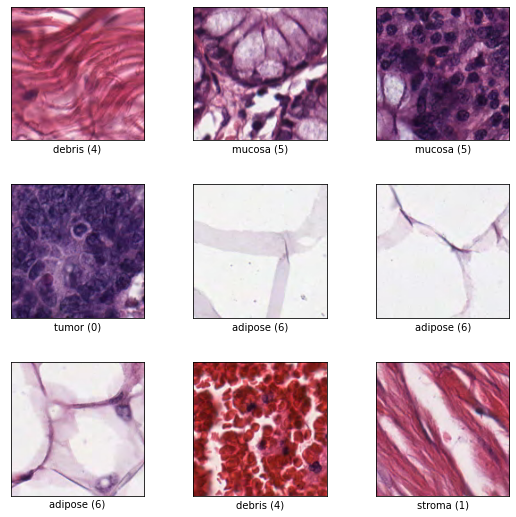

In [ ]:
# Visualize some random sample from the training set
fig = tfds.show_examples(training_set, dataset_info)

In [ ]:
#Compute probability distribution of the classes among the whole dataset

num_classes=np.zeros(8)

print("Assessing samples distribution over classes in training set..")
for sample in tqdm(training_set):
  num_classes[sample[1].numpy()]+=1

print("\nAssessing samples distribution over classes in validation set..")
for sample in tqdm(validation_set):
  num_classes[sample[1].numpy()]+=1

print("\nAssessing samples distribution over classes in test set..")
for sample in tqdm(test_set):
  num_classes[sample[1].numpy()]+=1

num_classes=num_classes/np.sum(num_classes)

Assessing samples distribution over classes in training set..


100%|██████████| 3500/3500 [00:03<00:00, 884.80it/s]



Assessing samples distribution over classes in validation set..


100%|██████████| 750/750 [00:00<00:00, 820.92it/s]



Assessing samples distribution over classes in test set..


100%|██████████| 750/750 [00:00<00:00, 801.97it/s]


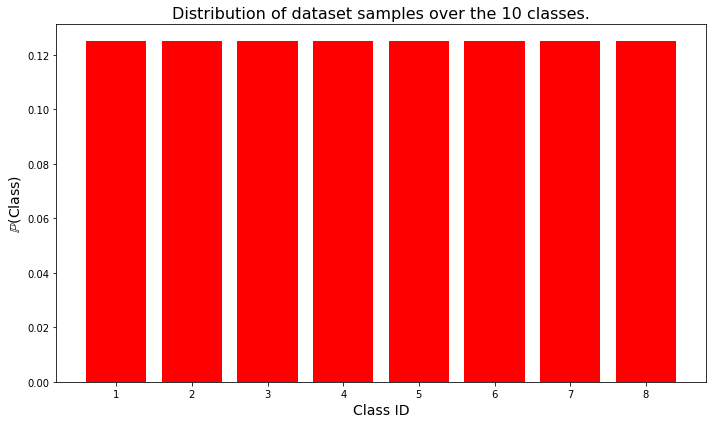

In [ ]:
plt.figure(figsize=(10,6),tight_layout=True)
plt.style.use('seaborn-deep')
plt.title((r'Distribution of dataset samples over the 10 classes.'),fontsize=16)
plt.xlabel((r'Class ID'),fontsize=14)
plt.ylabel((r'$\mathbb{P}$(Class)'),fontsize=14)
plt.bar(np.arange(1,9),num_classes, label=r'$\alpha_s$',color="red")
plt.show()

**DESCRIPTION OF THE CODE**: 

A small CNN architecture has been implemented. The CNN is made of 3 convolutional blocks, each made of a convolutional 2D layer, a MaxPooling layer  and a ReLu activation layer. 

Convolutional layers are implemented with respectively 128, 512 and 512 filters. Stride and padding applied to those layers has been chosen so to keep the spatial dimension of the feature maps equal to the spatial dimension of the input (i.e. 150*150 pixels).


MaxPooling layers parameters (i.e. filter size and the padding) have been tuned so to scale each spatial dimension of a factor respectively equal to 1/5, 1/5 and 1/6 after each convolutional block.

The volume of feature maps outputted by the last convolutional block has, in this way, a size equal to (512x1x1).   

After flattening of this volume is applied, the actual classifier is implemented through the usage of Dense layers, each respectively containing 512 and 8 (i.e. the total number of our classes) neurons. Softmax scores are finally outputted by the network.

During the training process, an EarlyStopping callback has been used with a patience value equal to 5 to avoid overfitting, plus a ModelCheckpoint callback to store only the best weights (w.r.t. the validation loss) found during the optimization process. 

Since no trasformation have been performed on top of the true labels (i.e. they take values {0,1,2,3,4,5,6,7}), SparseCategoricalCrossentropy has been chosen as loss function.

In all the data pipelines (i.e. the train, validation and test pipelines) a custom **normalizer()** function has been used in order to map pixel values in the range [0,1].

###Define the CNN Architecture

In [ ]:
# Define out own CNN with the Sequential API
conv_net = Sequential()

# 1st convolutional block
conv_net.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(150,150,3),activation="linear",padding='same'))
conv_net.add(MaxPooling2D((5, 5),padding='valid'))
conv_net.add(ReLU())

# 2nd convolutional block
conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same'))
conv_net.add(MaxPooling2D((5, 5),padding='valid'))
conv_net.add(ReLU())

# 3rd convolutional block
conv_net.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same'))
conv_net.add(MaxPooling2D((6, 6),padding='valid'))
conv_net.add(ReLU())

# Dense classifier
conv_net.add(Flatten())
conv_net.add(Dense(512, activation='linear'))
conv_net.add(ReLU())
conv_net.add(Dense(8, activation='softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 128)      0         
 )                                                               
                                                                 
 re_lu (ReLU)                (None, 30, 30, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 512)       590336    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 512)        0         
 2D)                                                             
                                                                 
 re_lu_1 (ReLU)              (None, 6, 6, 512)         0

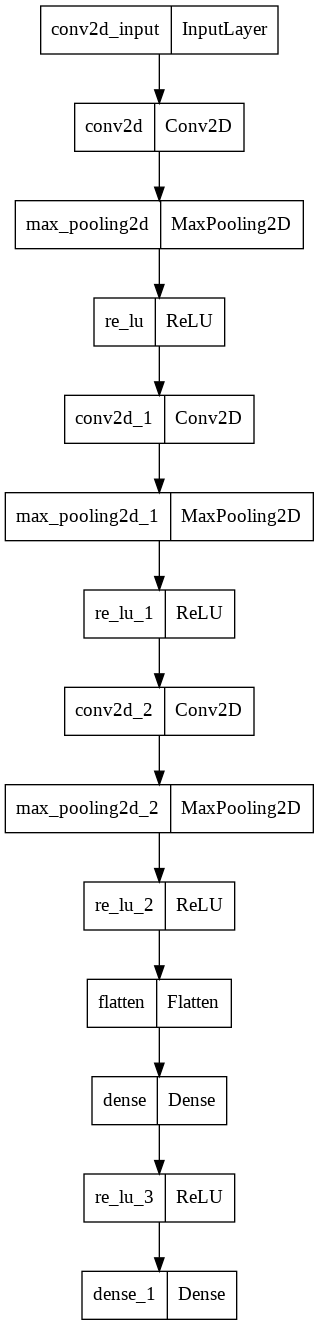

In [ ]:
# Visualize model summaries
conv_net.summary()
plot_model(conv_net)

In [ ]:
# Initialize selected loss function and optimizer
cross_entropy = tf.losses.SparseCategoricalCrossentropy()
adam = tf.optimizers.Adam()

# Initialize chosen callback
earlyStopping = EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min',restore_best_weights=True)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model
conv_net.compile(loss=cross_entropy, optimizer=adam,metrics=["accuracy"])


### Fit the CNN [$\sim$ 4 min to run]

In [ ]:
# Define our custom normalizer function. It will be used in all the dataset pipelines
# to normalize pixel values in the range [0,1]
def normalizer(x,y):
  return x/255,y

In [ ]:
# Define number of epochs and batch size
BATCH_SIZE = 32
EPOCHS = 30

#Build the data pipelines
train_set=training_set.shuffle(1000).batch(BATCH_SIZE).map(normalizer).prefetch(tf.data.AUTOTUNE)
val_set=validation_set.shuffle(1000).batch(BATCH_SIZE).map(normalizer).prefetch(tf.data.AUTOTUNE)
t_set=test_set.shuffle(1000).batch(BATCH_SIZE).map(normalizer).prefetch(tf.data.AUTOTUNE)

# Fit the model on top of the training data using the validation dataset 
# to monitor the model performances.
# Recall: early stopping in action!
conv_train=conv_net.fit(
    train_set, 
    epochs=EPOCHS,
    validation_data=val_set,
    callbacks=[earlyStopping, mcp_save])

Epoch 1/30
110/110 [==============================] - 14s 117ms/step - loss: 1.2939 - accuracy: 0.4497 - val_loss: 0.7762 - val_accuracy: 0.6840
Epoch 2/30
110/110 [==============================] - 12s 104ms/step - loss: 0.7873 - accuracy: 0.6771 - val_loss: 0.7385 - val_accuracy: 0.7107
Epoch 3/30
110/110 [==============================] - 12s 104ms/step - loss: 0.6496 - accuracy: 0.7494 - val_loss: 0.6644 - val_accuracy: 0.7467
Epoch 4/30
110/110 [==============================] - 12s 104ms/step - loss: 0.6070 - accuracy: 0.7766 - val_loss: 0.6097 - val_accuracy: 0.7640
Epoch 5/30
110/110 [==============================] - 13s 112ms/step - loss: 0.5344 - accuracy: 0.7986 - val_loss: 0.6528 - val_accuracy: 0.7387
Epoch 6/30
110/110 [==============================] - 12s 105ms/step - loss: 0.4626 - accuracy: 0.8294 - val_loss: 0.5584 - val_accuracy: 0.7920
Epoch 7/30
110/110 [==============================] - 12s 104ms/step - loss: 0.4343 - accuracy: 0.8406 - val_loss: 0.5382 - val_ac

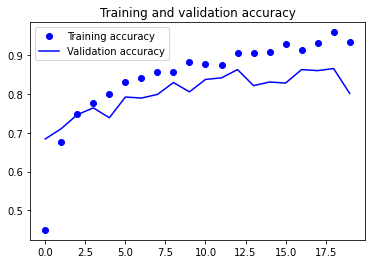

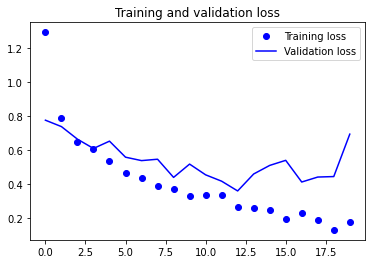

In [ ]:
# Plot loss and accuracy trends both on the training and validation set.
accuracy = conv_train.history['accuracy']
val_accuracy = conv_train.history['val_accuracy']
loss = conv_train.history['loss']
val_loss = conv_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###Test the CNN over the test set

In [ ]:
# Load best model
conv_net.load_weights('.mdl_wts.hdf5')

# Evaluate model performances on top of the test set..
print("Evaluating over test data..")
results = conv_net.evaluate(t_set)
print("\nTest loss: ",np.round(results[0],4),"\nTest accuracy: ", np.round(results[1],4))

Evaluating over test data..
24/24 [==============================] - 2s 48ms/step - loss: 0.3478 - accuracy: 0.8613

Test loss:  0.3478 
Test accuracy:  0.8613


###Model and data description

The whole dataset has been splitted to cope with 4 different disjoint tasks, i.e.:

*   **Task 0**: classify only images belonging to class 0 and 1;
*   **Task 1**: classify only images belonging to class 2 and 3;
*   **Task 2**: classify only images belonging to class 4 and 5;
*   **Task 3**: classify only images belonging to class 6 and 7;

After the splitting of the dataset into 8 subsets (one for each label), the training, validation and test set have been built for each task via the shuffled concatenation of the 2 relevant subsets.

In order to deal with the assigned problem with a Continual Learning approach, CNN architecture has to be modified: indeed, the outputs of the net will be given by **4 different binary heads** (i.e. heads containing 2 neurons each), each of them trained to deal with a single task. A visual description of the model is given in the following cells. Due to the fact that each head will give a binary softmax output *regardless* of the task involved, a re-mapping of the original features is needed so that in every task we will see only labels in {0,1}. Indeed, since we are in the **Task incremental setup** and we know by hypothesis the task we are working on, we will always be able to reconstruct the original label of an image knowing the task during which it has been classified. To perform the above mentioned label re-mapping (and the normalization of pixel values in the range [0,1]), a **normalizer_scaler()** custom function has been used in all the data pipelines.

The above descripted model has been implemented through the usage of the Functional API: it indeed gives the flexibility, upon the theoretical arrival of new tasks, to add new binary heads to the model, that can be following trained in an isolated way w.r.t. the rest of the model.

###Split the the dataset w.r.t. the label

In [ ]:
# Implement a custom function to split the data w.r.t. the label
def split_tasks(ds,n_tasks):
  return [ds.filter(lambda img, label: label == i) for i in range(n_tasks)]          

In [ ]:
# Define number of classes and tasks and split the dataset (ds_train, ds_test and ds_val
# are lists, each of them containing at index=0 all the training, validation
# and test samples with label=0, at index=1 all the samples with label=1 and so on)
n_classes=8
n_tasks=4

ds_train= split_tasks(training_set,n_classes)
ds_val=   split_tasks(validation_set,n_classes)
ds_test=  split_tasks(test_set,n_classes)

###Define multi-head architecture

In [ ]:
# Define multi-head architecture using the Sequential API
input = keras.Input(shape=(150, 150, 3), name="img")

x = Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(64,64,3),activation="linear",padding='same',name="conv_1")(input)
x = MaxPooling2D((5, 5),padding='valid',name="maxpool_1")(x)
x = ReLU(name="relu_1")(x)

x = Conv2D(128, kernel_size=(3, 3),strides=(1, 1),activation="linear",padding='same',name="conv_2")(x)
x = MaxPooling2D((5, 5),padding='valid',name="maxpool_2")(x)
x = ReLU(name="relu_2")(x)

x = Conv2D(128, kernel_size=(3, 3),strides=(1, 1),activation="linear",padding='same',name="conv_3")(x)
x = MaxPooling2D((6, 6),padding='valid',name="maxpool_3")(x)
x = ReLU(name="relu_3")(x)

x = Flatten(name="flatten")(x)
x = Dense(128, activation='linear',name="final_dense")(x)

head_0=Dense(2, activation='softmax',name="head_0")(x)
head_1=Dense(2, activation='softmax',name="head_1")(x)
head_2=Dense(2, activation='softmax',name="head_2")(x)
head_3=Dense(2, activation='softmax',name="head_3")(x)

mul_head = keras.Model(inputs=input, outputs=[head_0,head_1,head_2,head_3], name="multiple_heads")

Model: "multiple_heads"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 150, 150, 12  3584        ['img[0][0]']                    
                                8)                                                                
                                                                                                  
 maxpool_1 (MaxPooling2D)       (None, 30, 30, 128)  0           ['conv_1[0][0]']                 
                                                                                     

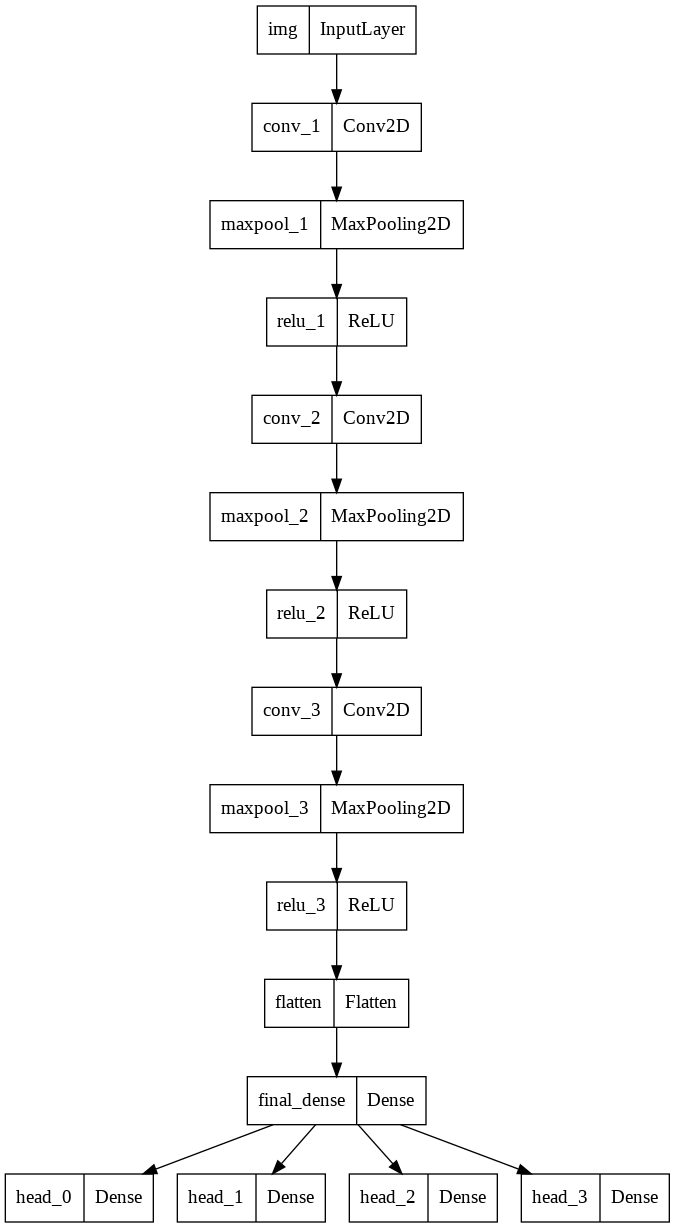

In [ ]:
# Plot model summaries
mul_head.summary()
plot_model(mul_head)

###Define auxiliary functions

In [ ]:
# Define our normalizer_scaler custom function that will be used in all the data
# pipelines. Aim of the scaler is to map all the labels (for all the tasks) in {0,1}
def normalizer_scaler(x,y,scale):
  return x/255,y-scale

In [ ]:
# Define custom function to compute accuracy of the model over the test set
# w.r.t. a defined task
def check_test_acc(model,task,test_data,normalizer_scaler):
  counter=0
  correct=0
  scale=2*task

  for x,y in test_data[scale].concatenate(test_data[scale+1]).shuffle(1000).batch(1).map(lambda x,y: normalizer_scaler(x,y, scale)):
    counter+=1
    if tf.math.argmax(model(x)[task],1).numpy()[0] == y.numpy()[0]:
      correct+=1

  return correct/counter

###Training the multi-head model: task 0 and Fisher matrixes
First of all, we train the model on top of the **task 0** training and validation set, computing the cross entropy loss only over the outputs of the **head_0** (i.e. the head dealing with task 0). Of course, warnings will be raised by the system since for all the parameters contained in the **head_1**, **head_2** and **head_3** layers we won't have any gradient. Code is provided to mute those warnings.

After training on task 0, model parameters are stored and a Fisher matrix will be computed for each layer of the model. Both of these elements will be needed to implement **EWC** regularization.

After the training on task 0, a dictionary element is built: at each key, the **Fisher matrix** related to the appropriate layer of the multi-head architecture it's stored.

###Task 0 [$\sim$ 2 min to run]

In [ ]:
# Define custom function to compute Fisher matrix
def compute_F_matrixes(model, task_set, size_of_estimate,task_id):

  # Build a dictionary: at each key it will store the Fisher matrix w.r.t. a particular model layer
  fisher_matrixes = {n: tf.zeros_like(p.value()) for n, p in enumerate(model.trainable_variables)}
 
  # For each of the image into the inputted dataset:
  for i, (imgs, labels) in enumerate(task_set.take(size_of_estimate)):
    # Initialize gradients storage
    with tf.GradientTape() as tape:

      # Compute the predictions (recall: we will just take the prediction from 
      # the head related to the actual task)
      predictions = model(imgs)[task_id]

      # Compute the logarithm of the predictions
      log_likelihood= tf.math.log(predictions)

    # Attach gradients over the log_likelihood to log_likelihood_grads
    log_likelihood_grads = tape.gradient(log_likelihood, model.trainable_variables)

    # Compute Fisher matrix at each layer (if existing)
    for i, gradients in enumerate(log_likelihood_grads):
      if gradients != None:
        fisher_matrixes[i] += tf.math.reduce_mean(gradients ** 2, axis=0) / size_of_estimate
 
  return fisher_matrixes

###############################################################################################################################
## Even if dealing with a completely different model (single head outputting logits)                                         ##
## the compute_F_matrixes() code is inpired to the article https://seanmoriarity.com/2020/10/18/continual-learning-with-ewc/ ##
###############################################################################################################################

In [ ]:
#Define number of epochs and batch size
EPOCHS=5
BATCH_SIZE=32

# Uncomment the following line if wanings raised for the lack
# of gradients during each task want to be muted. 
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Compile the model and fit it w.r.t. the outputs given by the 1st head
# (i.e. the one dealing with task=0)
task=0
scale=task*2

mul_head.compile(loss={'head_0': cross_entropy},
                optimizer='adam',
                metrics={'head_0': "accuracy"})

training_set_task=ds_train[2*task].concatenate(ds_train[2*task+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, scale)).prefetch(tf.data.AUTOTUNE)
validation_set_task=ds_val[2*task].concatenate(ds_val[2*task+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, scale)).prefetch(tf.data.AUTOTUNE)

mul_head_train = mul_head.fit(training_set_task,
                              epochs=EPOCHS,
                              validation_data=validation_set_task)

# Build a list to copy all the model parameters at the end of the training phase of task=0
task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]

# Compute Fisher matrixes after the training done on task=0
F = compute_F_matrixes(mul_head, validation_set_task, size_of_estimate=500,task_id=task)

Epoch 1/5


28/28 [==============================] - 14s 269ms/step - loss: 0.5177 - head_0_loss: 0.5177 - head_0_accuracy: 0.7566 - val_loss: 0.1099 - val_head_0_loss: 0.1099 - val_head_0_accuracy: 0.9600
Epoch 2/5
28/28 [==============================] - 9s 121ms/step - loss: 0.0766 - head_0_loss: 0.0766 - head_0_accuracy: 0.9760 - val_loss: 0.0501 - val_head_0_loss: 0.0501 - val_head_0_accuracy: 0.9900
Epoch 3/5
28/28 [==============================] - 9s 120ms/step - loss: 0.0527 - head_0_loss: 0.0527 - head_0_accuracy: 0.9817 - val_loss: 0.0465 - val_head_0_loss: 0.0465 - val_head_0_accuracy: 0.9900
Epoch 4/5
28/28 [==============================] - 9s 121ms/step - loss: 0.0403 - head_0_loss: 0.0403 - head_0_accuracy: 0.9920 - val_loss: 0.1773 - val_head_0_loss: 0.1773 - val_head_0_accuracy: 0.9400
Epoch 5/5
28/28 [==============================] - 9s 122ms/step - loss: 0.0695 - head_0_loss: 0.0695 - head_0_accuracy: 0.9794 - val_loss: 0.0474 - val_head_0_loss: 0.0474 - val_head_0_accuracy: 0

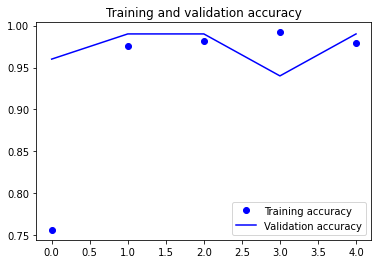

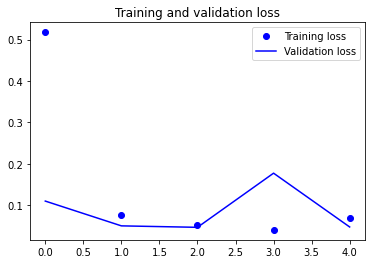

In [ ]:
# Plot performance of the model over task=0
accuracy = mul_head_train.history['head_0_accuracy']
val_accuracy = mul_head_train.history['val_head_0_accuracy']
loss = mul_head_train.history['head_0_loss']
val_loss = mul_head_train.history['val_head_0_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###Training the multi-head model: other tasks
In order to show the catastrophic-forgetting problem, 2 different training strategies have been applied. (Recall: re-definition of the multi-head architecture and fit of the model over task 0 is needed before the run of those 2 approaches so to perform a realistic comparison between the 2 approaches).

**Training without regularization**

In the first approach, we train all the other heads using a simple cross entropy loss without any regularization therm. By the accuracy results of the model over the different test sets, is clear how catastrophic-forgetting is occurrring, abruptly reducing the performances over seen tasks: indeed, after seeing the last task, the multi-head model acts pretty much like a random classifier when dealing with tasks 0, 1 and 2. 

**Training with regularization**

In the second approach, **EWC** regularization has been implemented. We can see how the effects of catastrophic forgetting are way dampened, even if somehow the model find difficult to find the optimal parameters during the last task (i.e. during task 3 learning the accuracy growth is slower). We might interpret that as a *disjointness* measure between the manifold on top of which optimal parameters for task 3 can be found and the manifolds on top of which optimal parameters for task 0, 1 and 2 can be found. Or, again, that might be due to the fact that during the last task we are also trying to classify the **Empty** class, images of which might contain very different features w.r.t. the images belonging to other tasks.  It turns out that a greater amount of learning epochs (e.g. 10) gives the optimes the time needed to reach optimal parameters also to deal with task 3. Nevertheless, for the time efficiency of the code, number of epochs has been kept equal to 5. 

After some fine tuning, training each head for 5 epochs with a regularization importance $\lambda=100$ result in a training procedure that well balances time efficiency and the robustness of the model robust against catastrophic forgetting.

<u> We also would like to highlight the fact that increasing the number of epochs in the approach without regularization increase the catastrophic forgetting, while in the EWC regularized approach (tuning appropriately the $\lambda$ value) catastrophic forgetting reduces as we increase the epochs.</u>

###Task 1, 2, 3


In [ ]:
# A wrapper has been used in the custom loss to send the extra needed parameters in the loss computation,
# i.e. the old model parameters, the Fisher matrixes and the Lambda control value
def EWC_loss(F,task_prev_param,Lambda): 

  def custom_loss(y_true, y_pred):
    # Compute standard cross entropy loss
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
    normal_loss=loss(y_true,y_pred)

    # Compute EWC regularization therm
    regularization_value=tf.constant([0.])
    for layer in range(len(F)):
      regularization_value+=tf.reduce_sum(F[layer]*(task_prev_param[layer]-mul_head.trainable_variables[layer])**2)

    # Return the standard cross entropy loss + EWC regularization
    return normal_loss+regularization_value*Lambda
  return custom_loss

####Without EWC regularization (cross entropy on each head) [$\sim$ 2 min to run]

In [ ]:
# For all the tasks other than the 0 task:
for task in range(1,n_tasks):
  
  print("\n\n##############################\n\nWorking on task {}\n\n##############################\n\n".format(task))

  # Compile the model training only the relevan head w.r.t. the task we are dealing with
  mul_head.compile(loss={'head_{}'.format(task): cross_entropy},
                  optimizer='adam',
                  metrics={'head_{}'.format(task): "accuracy"})

  # Define the scale parameter needed to remap the labels into {0,1} during each task
  scale=2*task

  # Build data pipelines for training and validation set
  training_set_task=ds_train[task*2].concatenate(ds_train[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, scale)).prefetch(tf.data.AUTOTUNE)
  validation_set_task=ds_val[task*2].concatenate(ds_val[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, scale)).prefetch(tf.data.AUTOTUNE)

  # Train the model
  mul_head_train = mul_head.fit(training_set_task,
                                epochs=EPOCHS,
                                validation_data=validation_set_task)



##############################

Working on task 1

##############################


Epoch 1/5


28/28 [==============================] - 11s 177ms/step - loss: 0.4168 - head_1_loss: 0.4168 - head_1_accuracy: 0.8169 - val_loss: 0.2502 - val_head_1_loss: 0.2502 - val_head_1_accuracy: 0.8750
Epoch 2/5
28/28 [==============================] - 10s 158ms/step - loss: 0.2283 - head_1_loss: 0.2283 - head_1_accuracy: 0.9062 - val_loss: 0.3941 - val_head_1_loss: 0.3941 - val_head_1_accuracy: 0.8352
Epoch 3/5
28/28 [==============================] - 9s 119ms/step - loss: 0.2341 - head_1_loss: 0.2341 - head_1_accuracy: 0.9027 - val_loss: 0.2351 - val_head_1_loss: 0.2351 - val_head_1_accuracy: 0.8807
Epoch 4/5
28/28 [==============================] - 9s 134ms/step - loss: 0.2146 - head_1_loss: 0.2146 - head_1_accuracy: 0.9153 - val_loss: 0.2954 - val_head_1_loss: 0.2954 - val_head_1_accuracy: 0.8920
Epoch 5/5
28/28 [==============================] - 9s 118ms/step - loss: 0.1893 - head_1_loss: 0.1893 - head_1_accuracy: 0.9222 - val_loss: 0.2235 - val_head_1_loss: 0.2235 - val_head_1_accuracy: 

28/28 [==============================] - 11s 169ms/step - loss: 0.2473 - head_2_loss: 0.2473 - head_2_accuracy: 0.9096 - val_loss: 0.1868 - val_head_2_loss: 0.1868 - val_head_2_accuracy: 0.9110
Epoch 2/5
28/28 [==============================] - 10s 152ms/step - loss: 0.1631 - head_2_loss: 0.1631 - head_2_accuracy: 0.9405 - val_loss: 0.1755 - val_head_2_loss: 0.1755 - val_head_2_accuracy: 0.9267
Epoch 3/5
28/28 [==============================] - 9s 120ms/step - loss: 0.1183 - head_2_loss: 0.1183 - head_2_accuracy: 0.9531 - val_loss: 0.1846 - val_head_2_loss: 0.1846 - val_head_2_accuracy: 0.9215
Epoch 4/5
28/28 [==============================] - 10s 119ms/step - loss: 0.1155 - head_2_loss: 0.1155 - head_2_accuracy: 0.9577 - val_loss: 0.2093 - val_head_2_loss: 0.2093 - val_head_2_accuracy: 0.9162
Epoch 5/5
28/28 [==============================] - 9s 121ms/step - loss: 0.0984 - head_2_loss: 0.0984 - head_2_accuracy: 0.9668 - val_loss: 0.2046 - val_head_2_loss: 0.2046 - val_head_2_accuracy:

28/28 [==============================] - 11s 176ms/step - loss: 0.6330 - head_3_loss: 0.6330 - head_3_accuracy: 0.5359 - val_loss: 0.3500 - val_head_3_loss: 0.3500 - val_head_3_accuracy: 0.9399
Epoch 2/5
28/28 [==============================] - 9s 120ms/step - loss: 0.2406 - head_3_loss: 0.2406 - head_3_accuracy: 0.9282 - val_loss: 0.2521 - val_head_3_loss: 0.2521 - val_head_3_accuracy: 0.9508
Epoch 3/5
28/28 [==============================] - 9s 118ms/step - loss: 0.1614 - head_3_loss: 0.1614 - head_3_accuracy: 0.9578 - val_loss: 0.1211 - val_head_3_loss: 0.1211 - val_head_3_accuracy: 0.9617
Epoch 4/5
28/28 [==============================] - 9s 121ms/step - loss: 0.1403 - head_3_loss: 0.1403 - head_3_accuracy: 0.9578 - val_loss: 0.1817 - val_head_3_loss: 0.1817 - val_head_3_accuracy: 0.9235
Epoch 5/5
28/28 [==============================] - 10s 158ms/step - loss: 0.1458 - head_3_loss: 0.1458 - head_3_accuracy: 0.9510 - val_loss: 0.1557 - val_head_3_loss: 0.1557 - val_head_3_accuracy: 

In [ ]:
# Compute performances of the fully trained (without EWC) model in each task
heads_accuracy_no_EWC=[]
for task in tqdm(range(n_tasks)):
  heads_accuracy_no_EWC.append(check_test_acc(mul_head,task,ds_test,normalizer_scaler))

100%|██████████| 4/4 [00:18<00:00,  4.54s/it]


In [ ]:
print("Performances over test sets after the sequential training\nTask 0 --> Task 1 --> Task 2 --> Task 3 \nAre (no EWC):\n\n")
for task in range(n_tasks):
  print("Accuracy of the model over test set for task {} is:".format(task), np.round(heads_accuracy_no_EWC[task],4))

Performances over test sets after the sequential training
Task 0 --> Task 1 --> Task 2 --> Task 3 
Are (no EWC):


Accuracy of the model over test set for task 0 is: 0.5029
Accuracy of the model over test set for task 1 is: 0.46
Accuracy of the model over test set for task 2 is: 0.5189
Accuracy of the model over test set for task 3 is: 0.9474


####With EWC regularization [$\sim$ 3 min to run]

In [ ]:
# For all the tasks other than the 0 task:
# RECALL: if coming from "Without EWC regularization" cell runs,
# remember to reinitialize the model and retrain on task 0 before!
for task in range(1,n_tasks):
  
  print("\n\n##############################\n\nWorking on task {}\n\n##############################\n\n".format(task))

  # Compile the model training only the relevan head w.r.t. the task we are dealing with
  mul_head.compile(loss={'head_{}'.format(task): EWC_loss(F,task_prev_param,Lambda=100)},
                  optimizer='adam',
                  metrics={'head_{}'.format(task): "accuracy"})

  # Define the scale parameter needed to remap the labels into {0,1} during each task
  scale=2*task

  # Build data pipelines for training and validation set
  training_set_task=ds_train[task*2].concatenate(ds_train[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, scale)).prefetch(tf.data.AUTOTUNE)
  validation_set_task=ds_val[task*2].concatenate(ds_val[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, scale)).prefetch(tf.data.AUTOTUNE)

  # Train the model
  mul_head_train = mul_head.fit(training_set_task,
                                epochs=EPOCHS,
                                validation_data=validation_set_task)

  
  # Copy the model parameters at the end of training. They will be used by EWC regularization during 
  # the training over the next task
  task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]

  # Compute the new Fisher matrixes (using the gradients computed after last task)
  # and update the Fisher matrixes by summing old Fisher matrixes with the new ones
  new_F= compute_F_matrixes(mul_head, validation_set_task, size_of_estimate=500,task_id=task)
  for layer in range(len(F)):
    F[layer]=F[layer]+new_F[layer]



##############################

Working on task 1

##############################


Epoch 1/5
28/28 [==============================] - 11s 142ms/step - loss: 1.9975 - head_1_loss: 1.9975 - head_1_accuracy: 0.7757 - val_loss: 0.6184 - val_head_1_loss: 0.6184 - val_head_1_accuracy: 0.8977
Epoch 2/5
28/28 [==============================] - 9s 124ms/step - loss: 0.3824 - head_1_loss: 0.3824 - head_1_accuracy: 0.9096 - val_loss: 0.3234 - val_head_1_loss: 0.3234 - val_head_1_accuracy: 0.8977
Epoch 3/5
28/28 [==============================] - 9s 125ms/step - loss: 0.2815 - head_1_loss: 0.2815 - head_1_accuracy: 0.9165 - val_loss: 0.3241 - val_head_1_loss: 0.3241 - val_head_1_accuracy: 0.8750
Epoch 4/5
28/28 [==============================] - 9s 122ms/step - loss: 0.2747 - head_1_loss: 0.2747 - head_1_accuracy: 0.9153 - val_loss: 0.2888 - val_head_1_loss: 0.2888 - val_head_1_accuracy: 0.8864
Epoch 5/5
28/28 [==============================] - 9s 125ms/step - loss: 0.2696 - head_1_loss: 0.2696

In [ ]:
# Compute performances of the fully trained (with EWC)  model in each task
heads_accuracy_EWC=[]
for task in tqdm(range(n_tasks)):
  heads_accuracy_EWC.append(check_test_acc(mul_head,task,ds_test,normalizer_scaler))


100%|██████████| 4/4 [00:13<00:00,  3.37s/it]


In [ ]:
print("Performances over test sets after the sequential training\nTask 0 --> Task 1 --> Task 2 --> Task 3\nAre (with EWC):\n\n")
for task in range(n_tasks):
  print("Accuracy of the model over test set for task {} is:".format(task), np.round(heads_accuracy_EWC[task],4))

Performances over test sets after the sequential training
Task 0 --> Task 1 --> Task 2 --> Task 3
Are (with EWC):


Accuracy of the model over test set for task 0 is: 0.9143
Accuracy of the model over test set for task 1 is: 0.935
Accuracy of the model over test set for task 2 is: 0.9297
Accuracy of the model over test set for task 3 is: 0.8526


###Intra-learning accuracy [$\sim$ 6 min to run]
The following cell has been built to produce an intra-learning accuracy plot over all the 4 tasks. Basically, the standard **fit()** function is called epoch by epoch, assessing at each epoch the performance of the model over the past (w.r.t. the actual learning epochs) tasks. Uncomment and execute the code if want to reproduce the output (Recall: reinitialize the multihead model and pretrain over task 0).
 A sample Intra-learning accuracy plot is reported below:


![](https://drive.google.com/uc?export=view&id=1eubuXHXAyVIezmcQ3MagYREAWZO3KClG)


In [ ]:
# RECALL: if coming from "Without/With EWC regularization" cell runs,
# remember to reinitialize the model and retrain on task 0 before!

# Define list of lists to store the performance of each head during the training
# executed for all the tasks
accuracies=[[] for task in range(n_tasks)]

# For all the tasks other than the 0 task:
for task in range(1,n_tasks):
  
  print("\n\n##############################\n\nWorking on task {}\n\n##############################\n\n".format(task))

  scale=2*task

  # For each of the epochs we want to train each head with:
  for epoch in range(EPOCHS):

    # Compile the model training only the relevan head w.r.t. the task we are dealing with
    mul_head.compile(loss={'head_{}'.format(task): EWC_loss(F,task_prev_param,Lambda=100)},
                    optimizer='adam',
                    metrics={'head_{}'.format(task): "accuracy"})

    # Build data pipelines for training and validation set
    training_set_task=ds_train[task*2].concatenate(ds_train[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, scale)).prefetch(tf.data.AUTOTUNE)
    validation_set_task=ds_val[task*2].concatenate(ds_val[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, scale)).prefetch(tf.data.AUTOTUNE)

    # Train the model for a single epoch
    mul_head_train = mul_head.fit(training_set_task,
                                  epochs=1,
                                  validation_data=validation_set_task)

    # Assess the performance of the previously trained heads during current training epoch by epoch
    for intra_task in range(task+1):
      accuracies[intra_task].append(check_test_acc(mul_head,intra_task,ds_test,normalizer_scaler))
 
  # Copy the model parameters at the end of training. They will be used by EWC regularization during 
  # the training over the next task
  task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]

  # Compute the new Fisher matrixes (using the gradients computed after last task)
  # and update the Fisher matrixes by summing old Fisher matrixes with the new ones
  new_F= compute_F_matrixes(mul_head, validation_set_task, size_of_estimate=500,task_id=task)
  for layer in range(len(F)):
    F[layer]=F[layer]+new_F[layer]



##############################

Working on task 1

##############################


28/28 [==============================] - 11s 138ms/step - loss: 2.0576 - head_1_loss: 2.0576 - head_1_accuracy: 0.9050 - val_loss: 0.5437 - val_head_1_loss: 0.5437 - val_head_1_accuracy: 0.8920


##############################

Working on task 2

##############################


28/28 [==============================] - 11s 141ms/step - loss: 1.9483 - head_2_loss: 1.9483 - head_2_accuracy: 0.9279 - val_loss: 0.4012 - val_head_2_loss: 0.4012 - val_head_2_accuracy: 0.9267


##############################

Working on task 3

##############################


28/28 [==============================] - 12s 179ms/step - loss: 2.7941 - head_3_loss: 2.7941 - head_3_accuracy: 0.6397 - val_loss: 0.6782 - val_head_3_loss: 0.6782 - val_head_3_accuracy: 0.8142


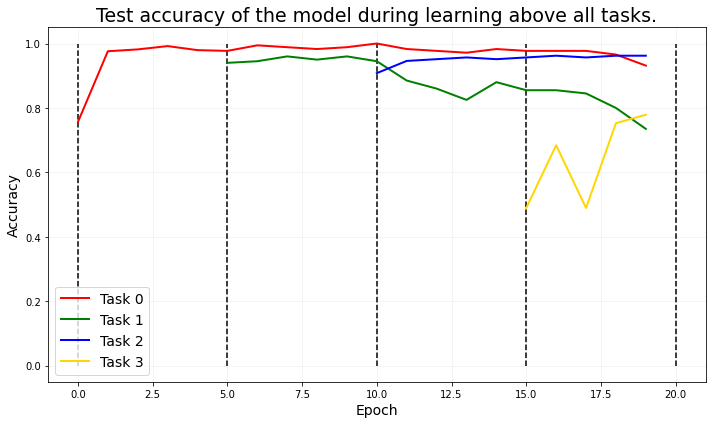

In [ ]:
# Append learning accuracy trend obtained during learning on task 0
accuracies[0]=accuracy+accuracies[0]

# Perform the plot
training_phases=np.array(range(0,EPOCHS*EPOCHS,EPOCHS))
colors=["red","green","blue", "gold"]
plt.figure(figsize=(10,6), tight_layout=True)
for task in range(n_tasks):
  plt.plot(range(EPOCHS*task,len(accuracies[task])+EPOCHS*task), accuracies[task], color=colors[task],linewidth=2, label='Task {}'.format(task))
plt.vlines(training_phases,0,1,linestyles="dashed")
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title(('Test accuracy of the model during learning above all tasks.'),fontsize=19)
plt.legend(fontsize=14,loc="lower left")
plt.grid(axis='x', color='0.95')
plt.grid(axis='y', color='0.95')
plt.savefig('intertask_accuracies.png')
plt.show()

###R matrix

In order to build the **R** matrix (where $R_{i,j}$ contain the test accuracy of the model over task $i$ after the training on task $j$), several training combinations has to be performed, and they are all summarized in the tuples contained in the **list_of_training_pairs**.

After the computation of the R matrix, 2 Contintinual Learning measures (i.e. Mean accuracy and the Backward transfer) are computed.

The Mean accuracy value obtained ($\sim$ 0.97) shows the model capability to cope with all tasks (and task-arrival combinations) on average with an high level of accuracy, while the Backward transfer value obtained ($\sim$ - 0.01) denotes how (on average) training on a new task is not decreasing nor increasing the performances on tasks that were previously seen during the training phase (this might be due to the high value of regularization importance $\lambda$=100 used during the construction of the $R$ matrix).  

###Mean accuracy and backward transfer: build the R matrix [$\sim$ 40 min to run]


In [ ]:
# Initialize R matrix to store model accuracies
R=np.zeros((n_tasks,n_tasks))

# Compute a list of tuples, each containing the task that will be executed first 
# at first element and the task that will be executed after at the second element
list_of_training_pairs=[tuple((first,second)) for first in range(n_tasks) for second in range(n_tasks)]
list_of_training_pairs

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [ ]:
# Suppress warning raised from lack of gradients
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# For each of the pairs
for pair in tqdm(list_of_training_pairs):
  
  # Extract first and second task
  first_task=pair[0]
  second_task=pair[1]
  
  # Compile the model for the first task
  mul_head.compile(loss={'head_{}'.format(first_task): cross_entropy},
                optimizer='adam',
                metrics={'head_{}'.format(first_task): "accuracy"})

  # Define data pipelines
  training_set_task=ds_train[first_task*2].concatenate(ds_train[first_task*2+1]).shuffle(5000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, first_task*2)).prefetch(tf.data.AUTOTUNE)
  validation_set_task=ds_val[first_task*2].concatenate(ds_val[first_task*2+1]).shuffle(5000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, first_task*2)).prefetch(tf.data.AUTOTUNE)

  # Train the model
  mul_head_train = mul_head.fit(training_set_task,
                              epochs=EPOCHS,
                              validation_data=validation_set_task,
                              verbose=0)

  # Store its parameters and compute the Fisher matrixes
  task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]
  F = compute_F_matrixes(mul_head, validation_set_task, size_of_estimate=500,task_id=first_task)

  # If second_task!=first_task, i.e. we are not computing results for the elements
  # of the R matrix laying on the diagonal
  if second_task!=first_task:
   
    # Compile the model for the second task, define its data pipelines and train it
    mul_head.compile(loss={'head_{}'.format(second_task): EWC_loss(F,task_prev_param,Lambda=100)},
                optimizer='adam',
                metrics={'head_{}'.format(second_task): "accuracy"})

    new_training_set_task=ds_train[second_task*2].concatenate(ds_train[second_task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, second_task*2)).prefetch(tf.data.AUTOTUNE)
    new_validation_set_task=ds_val[second_task*2].concatenate(ds_val[second_task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalizer_scaler(x,y, second_task*2)).prefetch(tf.data.AUTOTUNE)

    mul_head_train = mul_head.fit(training_set_task,
                                epochs=EPOCHS,
                                validation_data=validation_set_task,
                                verbose=0)
    
  # Store the performance of the so built model over the first task test set
  # in the appropriate position of the R matrix
  R[first_task,second_task]=check_test_acc(mul_head,first_task,ds_test,normalizer_scaler)

100%|██████████| 16/16 [26:00<00:00, 97.51s/it]


In [ ]:
# Visualize R matrix
R

array([[0.99428571, 0.99428571, 0.99428571, 0.99428571],
       [0.95      , 0.955     , 0.955     , 0.955     ],
       [0.96756757, 0.96216216, 0.96216216, 0.95675676],
       [0.97368421, 0.96842105, 0.97368421, 0.96315789]])

In [ ]:
# Compute the mean accuracy
mean_accuracy=0
for j in range(n_tasks):
  for i in range(j,n_tasks):
    mean_accuracy+=R[i,j]
mean_accuracy/=n_tasks*(n_tasks+1)/2
print("Mean accuracy value:",np.round(mean_accuracy,4))

Mean accuracy value: 0.967


In [ ]:
# Compute backward transfer
backward_transfer=0
for i in range(1,n_tasks):
  for j in range(i):
    backward_transfer+=R[i,j]-R[j,i]
backward_transfer/=n_tasks*(n_tasks-1)/2
print("Backward transfer value:",np.round(backward_transfer,4))

Backward transfer value: -0.009


### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

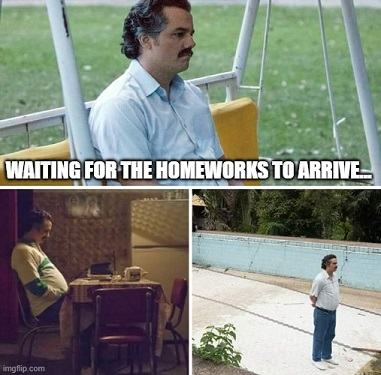